In [24]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np

In [25]:
eq_data_path = Path("data/raw/1/earthquake_data_tsunami.csv")
tsunami_data_path = Path("data/raw/1/tsunami_dataset.csv")

eq_df = pd.read_csv(eq_data_path)
tsunami_df = pd.read_csv(tsunami_data_path)

In [26]:
tsunami_df.head()

,ID,YEAR,MONTH,DAY,HOUR,MINUTE,LATITUDE,LONGITUDE,LOCATION_NAME,COUNTRY,...,CAUSE,EVENT_VALIDITY,EQ_MAGNITUDE,EQ_DEPTH,TS_INTENSITY,DAMAGE_TOTAL_DESCRIPTION,HOUSES_TOTAL_DESCRIPTION,DEATHS_TOTAL_DESCRIPTION,URL,COMMENTS
0,12,-330,NaN,NaN,NaN,NaN,40.00,25.000,"E. SPORADES ISLANDS, AEGEAN ISLANDS",GREECE,...,Earthquake,Very Doubtful Tsunami,7.0,NaN,NaN,NaN,NaN,NaN,https://www.ngdc.noaa.gov/hazel/view/hazards/t...,"330 B.C. Aegean Sea, Sporades Islands, 40 N 25..."
1,481,1764,2.0,11.0,NaN,NaN,51.45,-2.583,"BRISTOL, ENGLAND",UK,...,Unknown,Very Doubtful Tsunami,NaN,NaN,NaN,NaN,NaN,NaN,https://www.ngdc.noaa.gov/hazel/view/hazards/t...,"Reference #1894, in full: ""On Saturday the 11t..."
2,71,859,NaN,NaN,NaN,NaN,36.08,36.250,SAMANDAGI,TURKEY,...,Earthquake,Questionable Tsunami,NaN,NaN,3.0,NaN,NaN,NaN,https://www.ngdc.noaa.gov/hazel/view/hazards/t...,"859 (possibly 861), November. Levantian Sea, N..."
3,186,1580,1.0,NaN,NaN,NaN,40.00,128.000,YELLOW SEA,NORTH KOREA,...,Unknown,Very Doubtful Tsunami,NaN,NaN,1.0,NaN,NaN,NaN,https://www.ngdc.noaa.gov/hazel/view/hazards/t...,<P><blockquote><i>Reference #414:</i></blockqu...
4,5,-1300,NaN,NaN,NaN,NaN,39.96,26.240,"IONIAN COASTS, TROAD",TURKEY,...,Unknown,Questionable Tsunami,6.0,NaN,5.0,NaN,NaN,NaN,https://www.ngdc.noaa.gov/hazel/view/hazards/t...,1300 B.C. Ionian and Aegean Seas. References t...


In [27]:
min_year = np.min(eq_df['Year'])
int(min_year)

2001

In [28]:
print("Dataset Shape:", tsunami_df.shape)
print("\nColumn Names:", tsunami_df.columns.tolist())
print("\nMissing Values:\n", tsunami_df.isnull().sum())
print("\nFirst 5 rows:\n", tsunami_df.head())
print("\nStatistical Summary:\n", tsunami_df.describe())

Dataset Shape: (2259, 21)

Column Names: ['ID', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'LATITUDE', 'LONGITUDE', 'LOCATION_NAME', 'COUNTRY', 'REGION', 'CAUSE', 'EVENT_VALIDITY', 'EQ_MAGNITUDE', 'EQ_DEPTH', 'TS_INTENSITY', 'DAMAGE_TOTAL_DESCRIPTION', 'HOUSES_TOTAL_DESCRIPTION', 'DEATHS_TOTAL_DESCRIPTION', 'URL', 'COMMENTS']

Missing Values:
 ID                             0
YEAR                           0
MONTH                        104
DAY                          177
HOUR                         951
MINUTE                      1024
LATITUDE                       0
LONGITUDE                      0
LOCATION_NAME                  9
COUNTRY                        0
REGION                         1
CAUSE                          1
EVENT_VALIDITY                 0
EQ_MAGNITUDE                 785
EQ_DEPTH                    1352
TS_INTENSITY                1158
DAMAGE_TOTAL_DESCRIPTION    1204
HOUSES_TOTAL_DESCRIPTION    1653
DEATHS_TOTAL_DESCRIPTION    1585
URL                         

##### Using year, month, latitude and longitude; we will match and merge two datasets

In [29]:
tsunami_locations_and_info = tsunami_df[['YEAR', 'MONTH', 'LATITUDE', 'LONGITUDE', 'EQ_MAGNITUDE', 'EQ_DEPTH']].dropna()
before_tsunami_count = (eq_df['tsunami'] == 1).sum()
newly_assigned = []

print(f"Number of earthquakes with tsunami value 1 (before update): {before_tsunami_count}")
print(f"Number of earthquakes with tsunami value 0 (before update): {(eq_df['tsunami'] == 0).sum()}")

Number of earthquakes with tsunami value 1 (before update): 304
Number of earthquakes with tsunami value 0 (before update): 478


##### We did some researchs and found out the tolerance of difference in statistics of Earthquakes. We all know the statistics can differ from source to source. So we will use an adaptive tolarence getting method that we implemented using the information from the research we made

In [30]:
def get_adaptive_tolerances(magnitude, depth):
    # Latitude/Longitude tolerance (degrees)
    # Historical events and larger magnitudes have greater location uncertainty
    if magnitude >= 7.0:
        lat_tol = 2.0  # ~220 km at equator
        lon_tol = 2.0
    elif magnitude >= 6.0:
        lat_tol = 1.5  # ~165 km
        lon_tol = 1.5
    else:
        lat_tol = 1.0  # ~110 km
        lon_tol = 1.0
    
    # Magnitude tolerance
    # Research shows 0.3-0.6 typical, up to 1.0+ for great earthquakes
    if magnitude >= 7.5:
        mag_tol = 0.8  # Great earthquakes have larger discrepancies
    elif magnitude >= 6.5:
        mag_tol = 0.6
    else:
        mag_tol = 0.4  # Smaller events more consistent
    
    # Depth tolerance (km)
    # Deep earthquakes have much larger depth uncertainties
    if depth >= 300:
        depth_tol = 100  # Very deep events
    elif depth >= 100:
        depth_tol = 75   # Intermediate depth
    elif depth >= 50:
        depth_tol = 50
    else:
        depth_tol = 30   # Shallow events more precise
    
    return lat_tol, lon_tol, mag_tol, depth_tol

##### Used a helper method for calculating and matching the confidences

In [31]:
def calculate_match_confidence(lat_diff, lon_diff, mag_diff, depth_diff, 
                                lat_tol, lon_tol, mag_tol, depth_tol):
    # Normalized differences (0 = perfect match, 1 = at tolerance limit)
    lat_norm = min(lat_diff / lat_tol, 1.0)
    lon_norm = min(lon_diff / lon_tol, 1.0)
    mag_norm = min(mag_diff / mag_tol, 1.0)
    depth_norm = min(depth_diff / depth_tol, 1.0) if depth_tol > 0 else 0
    
    # Weighted confidence (location 40%, magnitude 40%, depth 20%) because research shows magnitude and location are most critical for tsunami matching.
    confidence = 100 * (1 - (0.2 * lat_norm + 0.2 * lon_norm + 
                             0.4 * mag_norm + 0.2 * depth_norm))
    return max(0, confidence)

##### Used a helper method for matching the times

In [32]:
def check_time_match(eq_year, eq_month, ts_year, ts_month):
    if eq_year != ts_year: # If the year is not the same, return False
        return False
    # Allow exact month or ±1 month difference
    month_diff = abs(eq_month - ts_month)
    return month_diff <= 1

##### Now we will match earthquakes with tsunami events using the helper methods, computes adaptive tolerances and diffs, scores confidence, then sets tsunami = 1 if best match ≥ 60 and logs details to newly_assigned.

In [33]:
for idx, row in eq_df.iterrows():
    if eq_df.loc[idx, 'tsunami'] == 0:
        # First filter by time
        same_time = tsunami_locations_and_info[
            tsunami_locations_and_info.apply(
                lambda x: check_time_match(row['Year'], row['Month'],
                                          x['YEAR'], x['MONTH']),
                axis=1
            )
        ]

        if not same_time.empty:
            best_match = None
            best_confidence = 0

            for _, ts_event in same_time.iterrows():
                # Get adaptive tolerances
                avg_magnitude = (row['magnitude'] + ts_event['EQ_MAGNITUDE']) / 2
                avg_depth = (row['depth'] + ts_event['EQ_DEPTH']) / 2
                lat_tol, lon_tol, mag_tol, depth_tol = get_adaptive_tolerances(
                    avg_magnitude, avg_depth
                )

                # Calculate differences
                lat_diff = abs(ts_event['LATITUDE'] - row['latitude'])
                lon_diff = abs(ts_event['LONGITUDE'] - row['longitude'])
                mag_diff = abs(ts_event['EQ_MAGNITUDE'] - row['magnitude'])
                depth_diff = abs(ts_event['EQ_DEPTH'] - row['depth'])

                # Check if within tolerances
                if (lat_diff <= lat_tol and lon_diff <= lon_tol and
                    mag_diff <= mag_tol and depth_diff <= depth_tol):

                    # Calculate confidence
                    confidence = calculate_match_confidence(
                        lat_diff, lon_diff, mag_diff, depth_diff,
                        lat_tol, lon_tol, mag_tol, depth_tol
                    )

                    # Keep best match
                    if confidence > best_confidence:
                        best_confidence = confidence
                        best_match = {
                            'ts_event': ts_event,
                            'lat_diff': lat_diff,
                            'lon_diff': lon_diff,
                            'mag_diff': mag_diff,
                            'depth_diff': depth_diff,
                            'confidence': confidence,
                            'tolerances': (lat_tol, lon_tol, mag_tol, depth_tol)
                        }

            # Assign tsunami if good match found. Threshold is 60% confidence.
            if best_match and best_confidence >= 60:
                eq_df.loc[idx, 'tsunami'] = 1

                ts = best_match['ts_event']
                newly_assigned.append({
                    'index': idx,
                    'year': row['Year'],
                    'month': row['Month'],
                    'eq_lat': row['latitude'],
                    'eq_lon': row['longitude'],
                    'eq_magnitude': row['magnitude'],
                    'eq_depth': row['depth'],
                    'ts_lat': ts['LATITUDE'],
                    'ts_lon': ts['LONGITUDE'],
                    'ts_magnitude': ts['EQ_MAGNITUDE'],
                    'ts_depth': ts['EQ_DEPTH'],
                    'lat_diff': best_match['lat_diff'],
                    'lon_diff': best_match['lon_diff'],
                    'mag_diff': best_match['mag_diff'],
                    'depth_diff': best_match['depth_diff'],
                    'confidence': best_match['confidence'],
                    'lat_tol': best_match['tolerances'][0],
                    'lon_tol': best_match['tolerances'][1],
                    'mag_tol': best_match['tolerances'][2],
                    'depth_tol': best_match['tolerances'][3]
                })

In [34]:
after_tsunami_count = (eq_df['tsunami'] == 1).sum()
int(after_tsunami_count)

428

In [35]:
after_tsunami_count = (eq_df['tsunami'] == 0).sum()
int(after_tsunami_count)

354

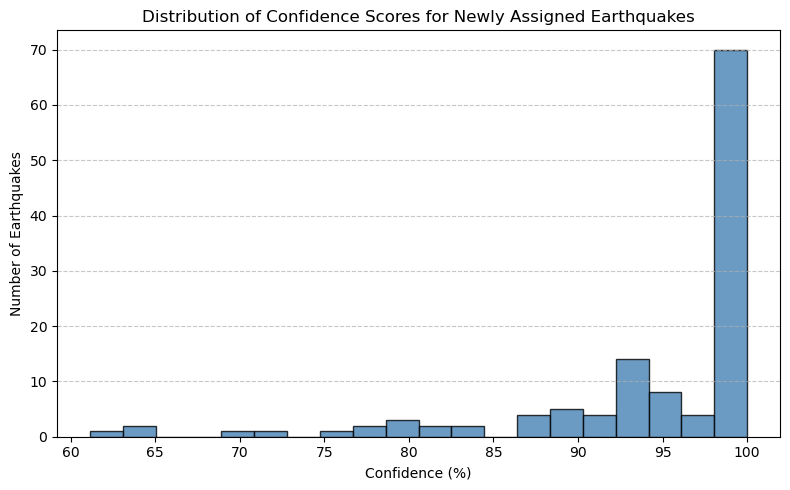

In [36]:
confidences = [eq['confidence'] for eq in newly_assigned]

plt.figure(figsize=(8, 5))
plt.hist(confidences, bins=20, color='steelblue', edgecolor='black', alpha=0.8)
plt.title(f'Distribution of Confidence Scores for Newly Assigned Earthquakes')
plt.xlabel('Confidence (%)')
plt.ylabel('Number of Earthquakes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

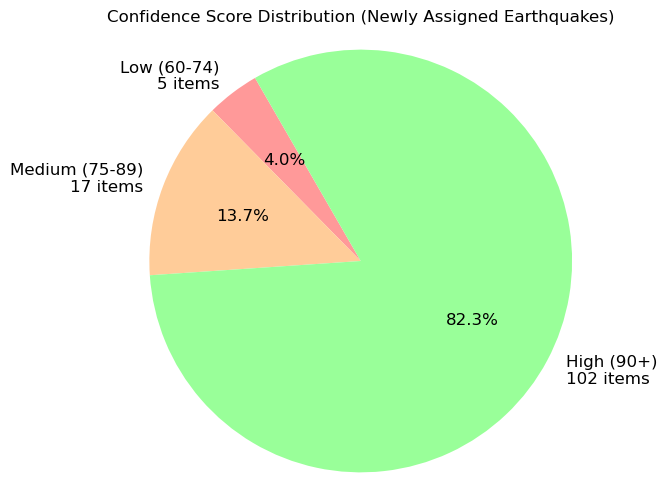

In [37]:
confidences = [eq['confidence'] for eq in newly_assigned]
total = len(confidences)

low_confidence = [eq for eq in newly_assigned if 60 <= eq['confidence'] < 75]
medium_confidence = [eq for eq in newly_assigned if 75 <= eq['confidence'] < 90]
high_confidence = [eq for eq in newly_assigned if eq['confidence'] >= 90]

counts = [len(low_confidence), len(medium_confidence), len(high_confidence)]
labels = [
    f'Low (60-74)\n{counts[0]} items', 
    f'Medium (75-89)\n{counts[1]} items', 
    f'High (90+)\n{counts[2]} items'
]
colors = ['#FF9999', '#FFCC99', '#99FF99']

percent_low = 100 * counts[0] / total if total > 0 else 0
percent_medium = 100 * counts[1] / total if total > 0 else 0
percent_high = 100 * counts[2] / total if total > 0 else 0

plt.figure(figsize=(6,6))
plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=120, textprops={'fontsize': 12})
plt.title('Confidence Score Distribution (Newly Assigned Earthquakes)')
plt.axis('equal')
plt.show()


Best 10 matches

In [38]:
top_matches = sorted(newly_assigned, key=lambda x: x['confidence'], reverse=True)[:10]

for n, eq in enumerate(top_matches, 1):
    print(f"\nMatch #{n}")
    print(f"Confidence score: {eq['confidence']}%")
    print(f"Year: {eq['year']}, Month: {eq['month']}")
    print(f"Latitude difference: {eq['lat_diff']} (tolerance: {eq['lat_tol']})")
    print(f"Longitude difference: {eq['lon_diff']} (tolerance: {eq['lon_tol']})")
    print(f"Magnitude difference: {eq['mag_diff']} (tolerance: {eq['mag_tol']})")
    print(f"Depth difference: {eq['depth_diff']} km (tolerance: {eq['depth_tol']})")


Match #1
Confidence score: 100.0%
Year: 2015.0, Month: 11.0
Latitude difference: 0.0 (tolerance: 1.5)
Longitude difference: 0.0 (tolerance: 1.5)
Magnitude difference: 0.0 (tolerance: 0.6)
Depth difference: 0.0 km (tolerance: 30)

Match #2
Confidence score: 100.0%
Year: 2012.0, Month: 9.0
Latitude difference: 0.0 (tolerance: 2.0)
Longitude difference: 0.0 (tolerance: 2.0)
Magnitude difference: 0.0 (tolerance: 0.8)
Depth difference: 0.0 km (tolerance: 30)

Match #3
Confidence score: 100.0%
Year: 2012.0, Month: 8.0
Latitude difference: 0.0 (tolerance: 2.0)
Longitude difference: 0.0 (tolerance: 2.0)
Magnitude difference: 0.0 (tolerance: 0.8)
Depth difference: 0.0 km (tolerance: 30)

Match #4
Confidence score: 100.0%
Year: 2012.0, Month: 8.0
Latitude difference: 0.0 (tolerance: 2.0)
Longitude difference: 0.0 (tolerance: 2.0)
Magnitude difference: 0.0 (tolerance: 0.6)
Depth difference: 0.0 km (tolerance: 30)

Match #5
Confidence score: 100.0%
Year: 2012.0, Month: 4.0
Latitude difference: 0.

Worst 10 matches

In [39]:
worst_10_matches = sorted(newly_assigned, key=lambda x: x['confidence'])[:10]

for idx, match in enumerate(worst_10_matches, 1):
    print(f"\nMatch #{idx}")
    print(f"Confidence score: {match['confidence']:.1f}%")
    print(f"Year: {match['year']}, Month: {match['month']}")
    print(f"Latitude difference: {match['lat_diff']:.3f}° (tolerance: {match['lat_tol']})")
    print(f"Longitude difference: {match['lon_diff']:.3f}° (tolerance: {match['lon_tol']})")
    print(f"Magnitude difference: {match['mag_diff']:.2f} (tolerance: {match['mag_tol']})")
    print(f"Depth difference: {match['depth_diff']:.1f} km (tolerance: {match['depth_tol']})")


Match #1
Confidence score: 61.1%
Year: 2011.0, Month: 8.0
Latitude difference: 0.003° (tolerance: 1.5)
Longitude difference: 0.062° (tolerance: 1.5)
Magnitude difference: 0.50 (tolerance: 0.6)
Depth difference: 7.0 km (tolerance: 30)

Match #2
Confidence score: 63.4%
Year: 2014.0, Month: 6.0
Latitude difference: 0.039° (tolerance: 1.5)
Longitude difference: 0.209° (tolerance: 1.5)
Magnitude difference: 0.40 (tolerance: 0.6)
Depth difference: 10.0 km (tolerance: 30)

Match #3
Confidence score: 64.5%
Year: 2016.0, Month: 12.0
Latitude difference: 0.093° (tolerance: 1.5)
Longitude difference: 0.182° (tolerance: 1.5)
Magnitude difference: 0.40 (tolerance: 0.6)
Depth difference: 7.7 km (tolerance: 30)

Match #4
Confidence score: 70.2%
Year: 2011.0, Month: 2.0
Latitude difference: 1.094° (tolerance: 1.5)
Longitude difference: 0.291° (tolerance: 1.5)
Magnitude difference: 0.10 (tolerance: 0.6)
Depth difference: 7.0 km (tolerance: 30)

Match #5
Confidence score: 72.1%
Year: 2013.0, Month: 2.0

In [40]:
len(high_confidence)

102

### We will add the high confidence datas to our dataset.

In [42]:
eq_df_updated = pd.read_csv(eq_data_path)

# Update tsunami values for high confidence matches (confidence >= 90)
for match in high_confidence:
    idx = match['index']
    if idx < len(eq_df_updated):
        eq_df_updated.loc[idx, 'tsunami'] = 1

# Export to new CSV file
output_path = Path("data/raw/1/earthquake_data_tsunami_updated.csv")
eq_df_updated.to_csv(output_path, index=False)

print(f"Updated {len(high_confidence)} high confidence matches (confidence >= 90%)")
print(f"Total earthquakes with tsunami=1: {(eq_df_updated['tsunami'] == 1).sum()}")
print(f"Total earthquakes with tsunami=0: {(eq_df_updated['tsunami'] == 0).sum()}")

Updated 102 high confidence matches (confidence >= 90%)
Total earthquakes with tsunami=1: 406
Total earthquakes with tsunami=0: 376
